In [2]:
from typing import NoReturn
import logging

import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

import scipy as sp

logging.basicConfig(level="DEBUG")
logger = logging.getLogger()

In [3]:
def convm(x: ArrayLike, p: int) -> np.ndarray:
    """Construct the convolution matrix of the signal x with p number of parameters.

    (N + p - 1) by p non-symmetric Toeplitz matrix
    """
    _x = np.array(x, dtype=complex).ravel()
    if p < 1:
        raise ValueError(f"{p=} must be greater or equal to 1.")

    N = len(_x) + 2 * p - 2
    # the signal centered over its support
    # needed for the signal information-preserving frequency spectrum
    xcol = (_x.copy()).reshape(-1, 1)
    logging.warning(f'\n{xcol=}')
    xpad = np.concatenate((np.zeros((p - 1, 1)), xcol, np.zeros((p - 1, 1))))
    logging.warning(f'{xpad=}\n')
    X = np.empty([len(_x) + p - 1, p], dtype=complex)
    for i in range(p):
        X[:, i] = xpad[p - i - 1:N - i, 0]
    return X

In [4]:
def covar(x: ArrayLike, p: int) -> np.ndarray:
    """Covariance Matrix.

    p x p hermitian toeplitz matrix of sample covariances
    """
    _x = np.array(x, dtype=complex)
    m = len(_x)
    # remove the mean
    _x = _x - np.mean(_x)
    conv = convm(x, p + 1)
    logging.warning(f'\n{conv.shape=}')
    logging.warning(f'\n{conv=}')
    R = conv.conjugate().transpose() @ conv / (m - 1)
    return R

In [5]:
def phd(x, p):
    Rx = sp.linalg.toeplitz(x)
    Rx = covar(x, p)
    d, v = np.linalg.eigh(Rx)
    index = np.argmin(d)
    vmin = v[:, index].copy()
    sigma = d[index]
    logging.warning(f'{v=}')
    logging.warning(f'{vmin=}')
    logging.warning(f'{sigma=}')
    rts = np.roots(vmin)
    vsig = np.delete(v, index, 1)
    phases = np.angle(rts)
    siggie = np.exp(1j * np.arange(p + 1).reshape(-1, 1) * phases)
    dtft = vsig.transpose() @ siggie.conjugate()
    dtft = np.abs(dtft)**2
    dsig = np.delete(d, index) - d[index]
    powers = np.linalg.solve(dtft, dsig)
    return sigma, vmin, powers, phases, vsig, d

In [6]:
def music(x, p, M):
    _x = np.array(x).ravel().reshape(-1, 1)
    if p + 1 > M:
        raise ValueError("Size of signal covariance matrix is inappropriate.")

    R = covar(x, M)
    d, v = np.linalg.eig(R)
    ddiag = np.diag(d)
    i = np.argsort(ddiag)
    # y = ddiag[i]
    nfft = max(len(_x) + 1, 1024)
    Px = np.zeros(nfft, dtype=complex)

    for j in range(M - p):
        Px = Px + np.abs(np.fft.fft(v[:, i[j]], nfft))

    Ax = Px
    Px = -20 * np.log10(Px)
    logging.debug(f'{Px.shape=}')

    return Px, Ax


In [7]:
def ev(x: ArrayLike, p: int, M: int) -> np.ndarray:
    if p + 1 > M:
        raise ValueError('Specified signal size is too small')

    _x = np.array(x, dtype=complex)
    R = covar(_x, M)
    d, v = np.linalg.eig(R)
    y = np.diag(d)
    yi = np.argsort(d)
    logger.warning(f'{d=}')
    logger.warning(f'{v=}')
    logger.warning(f'{y=}')
    logger.warning(f'{yi=}')
    nfft = max(1024, M + p + 1)
    Px = np.zeros((M - p, nfft))
    for j in range(M - p):
        Px = Px + np.abs(np.fft.fft(v[:, yi[j]], nfft))**2 / np.abs(d[j])

    Ax = Px
    Px = -10 * np.log10(Px)

    logger.warning(f'{Px.shape=}')

    return Px, Ax

In [8]:
p = 2
x = np.array([6, 1.92705 + 4.58522j, -3.42705 + 3.49541j], dtype=complex)
Px, Ax = music(x, p, 10)
print(f'{Px.shape=}')


xcol=array([[ 6.     +0.j     ],
       [ 1.92705+4.58522j],
       [-3.42705+3.49541j]])
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 6.     +0.j     ],
       [ 1.92705+4.58522j],
       [-3.42705+3.49541j],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ],
       [ 0.     +0.j     ]])

conv.shape=(13, 11)
conv=array([[ 6.     +0.j     ,  0.     +0.j     ,  0.     +0.j     ,
         0.     +0.j     ,  0.     +0.j     ,  0.     +0.j     ,
         0.     +0.j     ,  0.     +0.j     ,  0.     +0.j     ,
         0.     +0.j     ,  0.     +0.j     ],
       [ 1.92705+4.58522j

Px.shape=(11, 1024)


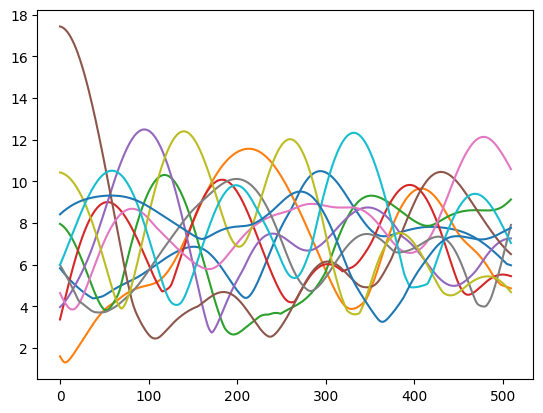

In [11]:
plt.plot(np.abs(Ax.transpose())[1:511])

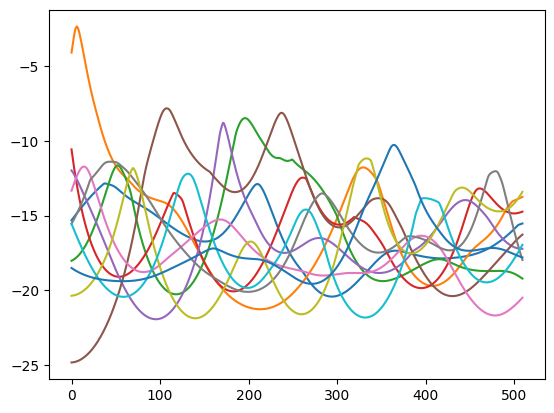

In [13]:
plt.plot(Px.transpose()[1:511])